In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\Vaibhavi\Downloads\CDC project\train_with_transport.csv")
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,dist_to_metro_m,dist_to_railway_m,dist_to_airport_m,log_dist_to_metro,log_dist_to_railway,log_dist_to_airport
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,47.4362,-122.187,1660,9240,4509.032100,4758.773727,6570.928065,8.414060,8.467955,8.790563
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,47.4034,-122.187,1720,3605,4020.531148,4023.458545,8960.128118,8.299418,8.300146,9.100651
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,47.2704,-122.313,1870,7455,3676.168762,5102.182604,3067.834505,8.209898,8.537620,8.029053
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,47.5321,-122.073,1240,750,1368.961138,10635.993144,11443.872232,7.222538,9.272093,9.345297
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,47.3715,-122.074,1590,8071,12032.816197,12051.634578,4461.963352,9.395476,9.397039,8.403568


In [2]:
df = df.drop_duplicates(subset="id").reset_index(drop=True)


In [3]:
df["date"] = pd.to_datetime(df["date"], format="%Y%m%dT%H%M%S")

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

df.drop(columns="date", inplace=True)


In [4]:
CURRENT_YEAR = 2015

df["house_age"] = CURRENT_YEAR - df["yr_built"]
df["renovated"] = (df["yr_renovated"] > 0).astype(int)
df["quality_area"] = df["sqft_living"] * df["grade"]


In [ ]:


# ============================================================
# SATELLITE IMAGE EMBEDDING EXTRACTION (EfficientNet-B4)
# ============================================================

import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms

# ===============================
# CONFIG
# ===============================
IMAGE_DIR = r"C:\Users\Vaibhavi\Downloads\CDC project\mapbox_images_2"
IMAGE_SIZE = 380   # Native resolution for EfficientNet-B4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================
# LOAD EFFICIENTNET-B4 (LAST LAYER)
# ===============================
effnet = models.efficientnet_b4(
    weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
)

# Remove classifier head → keep feature extractor
effnet.classifier = nn.Identity()

effnet.to(DEVICE)
effnet.eval()

EMBED_DIM = 1792
print("✅ EfficientNet-B4 loaded | Embedding dim:", EMBED_DIM)

# ===============================
# IMAGE TRANSFORMS (IMPORTANT)
# ===============================
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===============================
# IMAGE LOOKUP (ID → FILE)
# ===============================
image_files = {
    f.split("_")[0]: f
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith(".png")
}

# ===============================
# EMBEDDING FUNCTION
# ===============================
def extract_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        emb = effnet(x)  # (1, 1792)

    return emb.squeeze().cpu().numpy()

# ===============================
# MAIN EXTRACTION LOOP
# ===============================
rows = []

for pid in tqdm(df["id"].astype(str), desc="Extracting EfficientNet-B4 embeddings"):
    if pid not in image_files:
        continue

    img_path = os.path.join(IMAGE_DIR, image_files[pid])
    embedding = extract_embedding(img_path)

    row = {"id": pid}
    for i, val in enumerate(embedding):
        row[f"img_{i}"] = val

    rows.append(row)

img_emb_df = pd.DataFrame(rows)

print("✅ EfficientNet-B4 embeddings extracted")
print("Shape:", img_emb_df.shape)
df.to_csv("data/final_features.csv", index=False)


# EDA

In [ ]:
import seaborn as sns
# ---------- TOP-25 FEATURE IMPORTANCE (HORIZONTAL BARPLOT) ----------
import pandas as pd
import matplotlib.pyplot as plt

TOP_K = 25

# Feature names (same order as training)
feature_names = multimodal_features

# Extract gain-based importance from XGBoost
booster = best_model.get_booster()
importance_dict = booster.get_score(importance_type="gain")

# Build importance DataFrame
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": [importance_dict.get(f"f{i}", 0.0) for i in range(len(feature_names))]
})

# Keep only non-zero importance features
imp_df = imp_df[imp_df["importance"] > 0]

# Select top-25 features
imp_df = imp_df.sort_values("importance", ascending=False).head(TOP_K)

# Re-sort for horizontal plotting (small → large)
imp_df = imp_df.sort_values("importance", ascending=True)

# Plot
plt.figure(figsize=(10, 7))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 25 Feature Importances — Multimodal XGBoost")
plt.tight_layout()
plt.show()



In [6]:
import seaborn as sns

<Axes: xlabel='dist_to_metro_m', ylabel='price'>

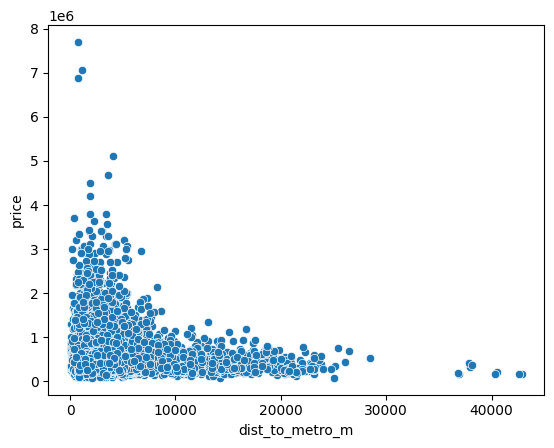

In [7]:
sns.scatterplot(x='dist_to_metro_m',y='price',data=df)

<Axes: xlabel='dist_to_railway_m', ylabel='price'>

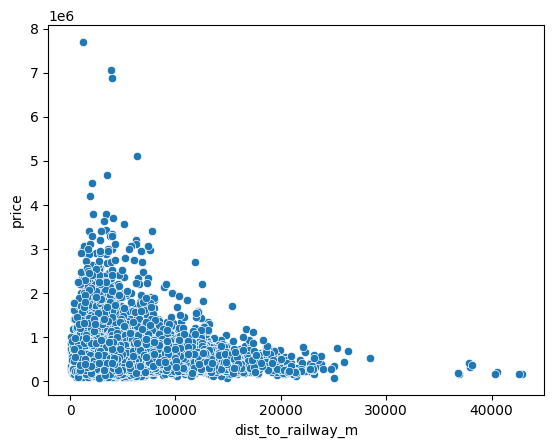

In [8]:
sns.scatterplot(x='dist_to_railway_m',y='price',data=df)

<Axes: xlabel='dist_to_airport_m', ylabel='price'>

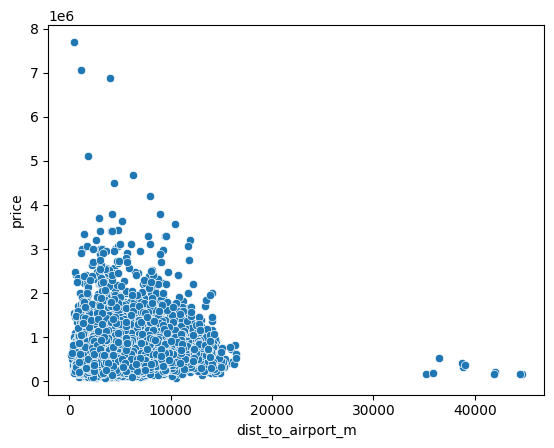

In [9]:
sns.scatterplot(x='dist_to_airport_m',y='price',data=df)

<Axes: xlabel='waterfront', ylabel='price'>

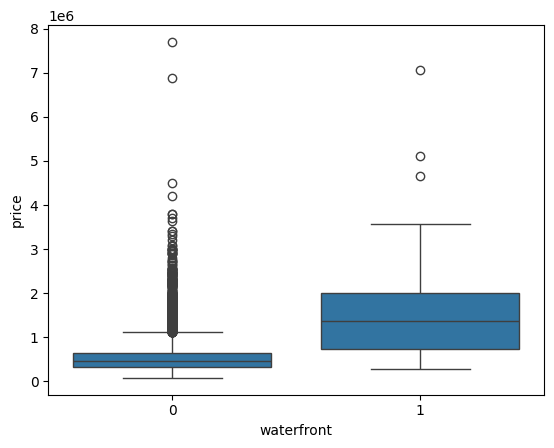

In [10]:
sns.boxplot(x='waterfront',y='price',data=df)

<Axes: xlabel='grade', ylabel='price'>

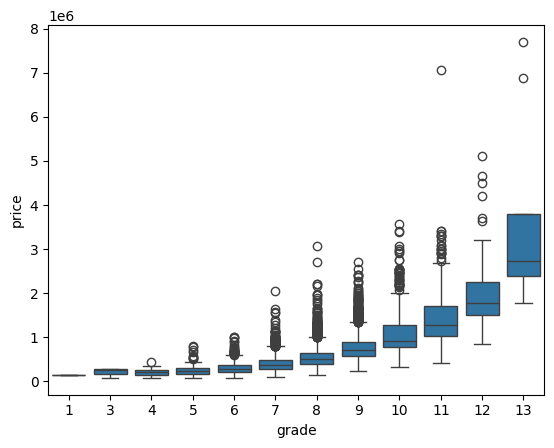

In [11]:
sns.boxplot(x='grade',y='price',data=df)

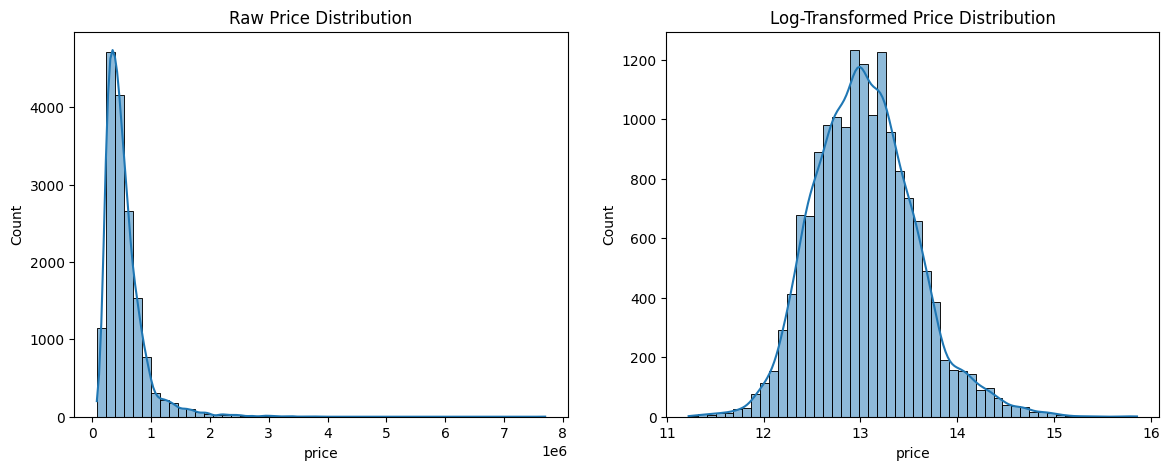

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df['price'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Raw Price Distribution")

sns.histplot(np.log(df['price']), bins=50, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Price Distribution")

plt.show()

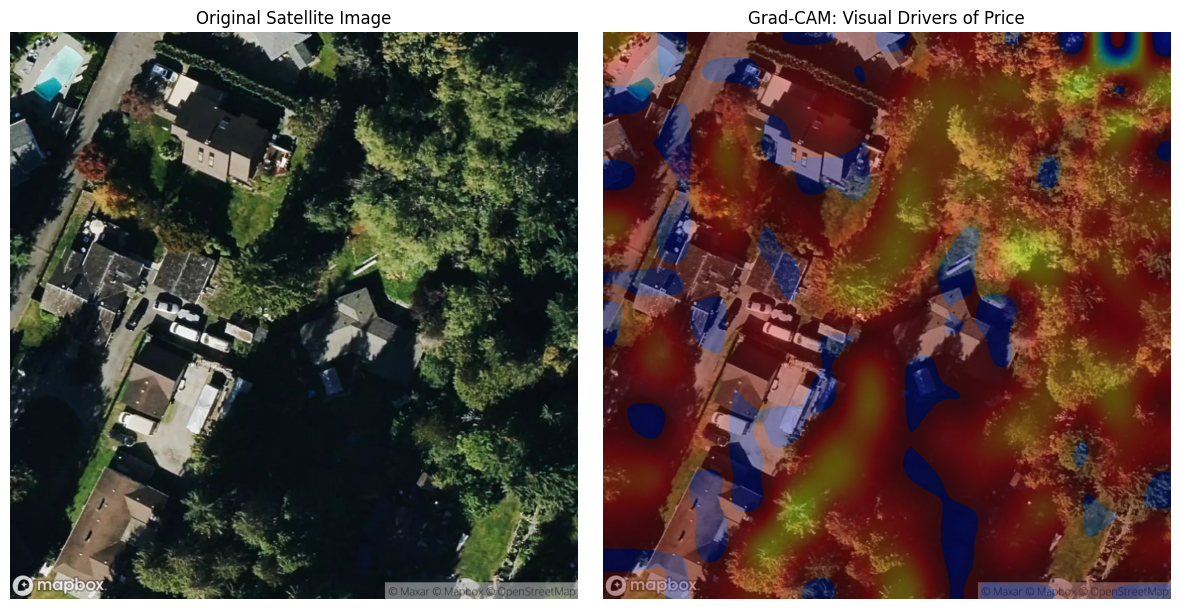

In [14]:
# ============================================================
# COMPLETE, UPDATED & CORRECTED GRAD-CAM (SIDE-BY-SIDE VIEW)
# EfficientNet-B4 | Original Image + Grad-CAM Overlay
# ============================================================

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn

# ===============================
# CONFIG
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 512

# ===============================
# LOAD EFFICIENTNET-B4 (FEATURE EXTRACTOR)
# ===============================
effnet = models.efficientnet_b4(
    weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
)
effnet.classifier = nn.Identity()   # remove FC head
effnet.to(DEVICE)
effnet.eval()

# ===============================
# IMAGE TRANSFORM
# ===============================
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===============================
# GRAD-CAM CLASS
# ===============================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()

        output = self.model(input_tensor)   # (1, 1792)
        score = output.mean()               # scalar for Grad-CAM
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy()

# ===============================
# INITIALIZE GRAD-CAM
# (use -3 for better spatial resolution)
# ===============================
target_layer = effnet.features[-3]
gradcam = GradCAM(effnet, target_layer)

# ===============================
# SIDE-BY-SIDE VISUALIZATION
# ===============================
def show_side_by_side_gradcam(img_path):
    # Load original image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Prepare input
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Generate CAM
    cam = gradcam.generate(input_tensor)

    # Resize CAM to image size
    cam_resized = cv2.resize(
        cam,
        (img_np.shape[1], img_np.shape[0]),
        interpolation=cv2.INTER_CUBIC
    )

    # Smooth CAM
    cam_resized = cv2.GaussianBlur(cam_resized, (31, 31), 0)

    # Heatmap
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized),
        cv2.COLORMAP_JET
    )

    # Overlay
    overlay = cv2.addWeighted(
        img_np, 0.65,
        heatmap, 0.35,
        0
    )

    # Plot side-by-side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Satellite Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM: Visual Drivers of Price")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ===============================
# RUN (EXAMPLE)
# ===============================
show_side_by_side_gradcam(r"C:\Users\Vaibhavi\Downloads\CDC project\mapbox_images_2\1200021_z18_s2.png")
